References:

   https://github.com/https-deeplearning-ai

   https://github.com/https-deeplearning-ai/tensorflow-2-public

   https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb#scrollTo=ygwa9AgRloYy
   
   https://www.tensorflow.org/tfx/serving/setup
   
   https://www.tensorflow.org/tfx/tutorials/serving/rest_simple 

  
  https://colab.research.google.com/github/tensorflow/federated/blob/master/docs/tutorials/custom_federated_algorithms_1.ipynb

  https://ai.googleblog.com/2017/04/federated-learning-collaborative.html

  https://eprint.iacr.org/2017/281.pdf

  https://research.google/pubs/pub47976/

  https://www.tensorflow.org/federated

  https://www.youtube.com/watch?v=89BGjQYA0uE

  

In [1]:
!pip install -q requests
##!pip install -Uq grpcio==1.26.0

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from tqdm import tqdm
import os
import json
import tempfile
import requests
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

# Simple detection model

## Select the Hub/TF2 Module to Use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [4]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data Preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the `rock_paper_scissors` dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Dividing the `train` split of this dataset into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [5]:
### this data goes in the root/  directory

(train_examples, validation_examples, test_examples), info = tfds.load('rock_paper_scissors',
                                                                       with_info=True, 
                                                                       as_supervised=True, 
                                                                       split=['train[:80%]',
                                                                              'train[80%:90%]',
                                                                              'train[90%:]'])

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [6]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

Now shuffle and batch the data


In [7]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [8]:
train_batches = train_examples.shuffle(num_examples // 4).batch(BATCH_SIZE).map(format_image).prefetch(1)
validation_batches = validation_examples.batch(BATCH_SIZE).map(format_image).prefetch(1)
test_batches = test_examples.batch(1).map(format_image)

Inspect a batch

In [9]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## Defining the Model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [10]:
do_fine_tuning = False #@param {type:"boolean"}

In [11]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [12]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

## Training the Model

In [14]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:
EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
63/63 [==============================] - 108s 1s/step - loss: 0.3641 - accuracy: 0.8864 - val_loss: 0.0960 - val_accuracy: 0.9921
Epoch 2/5
63/63 [==============================] - 100s 2s/step - loss: 0.0664 - accuracy: 0.9995 - val_loss: 0.0460 - val_accuracy: 1.0000
Epoch 3/5
63/63 [==============================] - 86s 1s/step - loss: 0.0360 - accuracy: 0.9995 - val_loss: 0.0294 - val_accuracy: 1.0000
Epoch 4/5
63/63 [==============================] - 86s 1s/step - loss: 0.0230 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 5/5
63/63 [==============================] - 90s 1s/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 1.0000


# Tensorflow Serving

## Save the Model

To load the trained model into TensorFlow Serving we first need to save it in the [SavedModel](https://www.tensorflow.org/guide/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/serving_config) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [ ]:
# MODEL_DIR = tempfile.gettempdir()

# version = 1

# export_path = os.path.join(MODEL_DIR, str(version))

# if os.path.isdir(export_path):
#     print('\nAlready saved a model, cleaning up\n')
#     !rm -r {export_path}

# model.save(export_path, save_format="tf")

# print('\nexport_path = {}'.format(export_path))  ## find model in /tmp/1 do not search it in /content/ file in colab
# !ls -l {export_path}

### Fetch the Keras session and save the model
### The signature definition is defined by the input and output tensors,
### and stored with the default serving key


MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

### deprecated:
# tf.compat.v1.saved_model.simple_save(
#     keras.backend.get_session(), 
#     export_path, 
#     inputs = {model.input}, 
#     outputs = {t.name:t for t in model.outputs}, 
#     legacy_init_op=None
# )

print('\nSaved model:')
!ls -l {export_path}

## Examine Your Saved Model

We'll use the command line utility `saved_model_cli` to look at the `MetaGraphDefs` and `SignatureDefs` in our SavedModel. The signature definition is defined by the input and output tensors, and stored with the default serving key.

In [ ]:
### NOTE: when it comes to shapes, input, output - ignore the minus one

!saved_model_cli show --dir {export_path} --all

## Add TensorFlow Serving Distribution URI as a Package Source

**Warning: If you are running this NOT on a Google Colab,** following cells
will install packages on the system with root access. If you want to run it in
a local Jupyter notebook, please proceed with caution.

### Add TensorFlow Serving distribution URI as a package source:

We're preparing to install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) since this Colab runs in a Debian environment.  We'll add the `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Note that we're running as root.

Note: This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving.

In [156]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

## Install TensorFlow Serving

Now that the Aptitude packages have been updated, we can use the `apt-get` command to install the TensorFlow model server.

In [ ]:
### !apt-get install tensorflow-model-server

# TODO: Use the latest model server version when colab supports it.
#!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server
# We need to install Tensorflow Model server 2.8 instead of latest version
# Tensorflow Serving >2.9.0 required `GLIBC_2.29` and `GLIBCXX_3.4.26`. Currently colab environment doesn't support latest version of`GLIBC`,so workaround is to use specific version of Tensorflow Serving `2.8.0` to mitigate issue.

# !echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
# !apt update

!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb'
!dpkg -i tensorflow-model-server_2.8.0_all.deb
!pip3 install tensorflow-serving-api==2.8.0

## Run the TensorFlow Model Server

We will now launch the TensorFlow model server with a bash script. We will use the argument `--bg` to run the script in the background.

Our script will start running TensorFlow Serving and will load our model. Here are the parameters we will use:

* `rest_api_port`: The port that you'll use for requests.


* `model_name`: You'll use this in the URL of your requests.  It can be anything.


* `model_base_path`: This is the path to the directory where you've saved your model.

Also, because the variable that points to the directory containing the model is in Python, we need a way to tell the bash script where to find the model. To do this, we will write the value of the Python variable to an environment variable using the `os.environ` function.

In [159]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [160]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=detect \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [161]:
## take look at the server log
## NOTE: if connection will not work for the repeated/second time just delete tensorflow-model-server from /content/
   ## and reinstall the serving distribution URI and tfserving again
!tail server.log

## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

In [ ]:
def slice_of_testimgs(which_example=1, show=False, test_examples=test_examples, format_image=format_image):

  for data in test_examples.take(which_example):

      ### model.input.shape ### model.output.shape
      image, label = data
      image, label = format_image(image, label)

  if show:  
    print("Label: {}".format(label))
    plt.imshow(image.numpy().squeeze(), cmap=plt.cm.binary)
    plt.show()

  label = label.numpy()
  image = np.expand_dims(image.numpy().squeeze(), axis=0)

  return image, label   


import random
random_example = 1 if 0 else random.choice(range(len(test_examples)-1))

image, label = slice_of_testimgs(random_example, show=True)  
print(f'Input Shape: {image.shape}, Label: {label}, Example N: {random_example}')

Now create the JSON object for a batch of three inference requests, and see how well our model recognizes things:

In [163]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": slice_of_testimgs(random_example)[0].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 6827393, 0.9771358966827393, 0.9771358966827393]]]]}


#### Make REST requests

Newest version of the servable

We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples.  We'll ask our server to give us the latest version of our servable by not specifying a particular version.

In [164]:
headers = {"content-type": "application/json"}
                                                            ## detect is what we called the model and 
                                                            ## :predict tag is for prediction
json_response = requests.post('http://localhost:8501/v1/models/detect:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)["predictions"]

class_names = info.name.split('_')

print('The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[label], label))

The model thought this was a rock (class 0), and it was actually a rock (class 0)


In [165]:
json_response.text

'{\n    "predictions": [[0.991667449, 0.00468994165, 0.00364255207]\n    ]\n}'

#### A particular version of the servable

Now let's specify a particular version of our servable.  Since we only have one, let's select version 1.  We'll also look at all three results.

In [166]:
# docs_infra: no_execute
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/detect/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']


print('The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[label], label))

The model thought this was a rock (class 0), and it was actually a rock (class 0)


# Prepare Tensorflow Js files inc. json to use the model in browser and web applications

In [ ]:
!pip install -q tensorflowjs

In [168]:
import time

saved_model_path = "./{}.h5".format(int(time.time()))
model.save(saved_model_path)

In [169]:
## all converted files should be coppied to corresponding directory of web application, 
## In same directory where the model is hosted, html or whatever file it is.

!tensorflowjs_converter --input_format=keras {saved_model_path} ./web/

2023-02-08 18:18:15.840155: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-08 18:18:15.840424: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-08 18:18:15.840460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# Prepare TF Lite flatbuffer for deploiment mobile and test it's performance in colab

## Export the Model

In [170]:
RPS_SAVED_MODEL = "rps_saved_model"

Export the SavedModel

In [171]:
tf.saved_model.save(model, RPS_SAVED_MODEL)

In [172]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2023-02-08 18:19:03.945605: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-08 18:19:03.945846: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-08 18:19:03.945890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [173]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [174]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense')}


## Convert Using TFLite's Converter - **important how to's**

Load the TFLiteConverter with the SavedModel

In [175]:
##converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)

### Post-Training Quantization
The simplest form of post-training quantization quantizes weights from floating point to 8-bits of precision. This technique is enabled as an option in the TensorFlow Lite converter. At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation.

In [176]:
##converter.optimizations = [tf.lite.Optimize.DEFAULT]

### Post-Training Integer Quantization
We can get further latency improvements, reductions in peak memory usage, and access to integer only hardware accelerators by making sure all model math is quantized. To do this, we need to measure the dynamic range of activations and inputs with a representative data set. You can simply create an input data generator and provide it to our converter.

In [177]:
# def representative_data_gen():
#     for input_value, _ in test_batches.take(100):
#         yield [input_value]

In [178]:
##converter.representative_dataset = representative_data_gen

The resulting model will be fully quantized but still take float input and output for convenience.

Ops that do not have quantized implementations will automatically be left in floating point. This allows conversion to occur smoothly but may restrict deployment to accelerators that support float. 

### Full Integer Quantization

To require the converter to only output integer operations, one can specify:

In [179]:
##converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

### Finally convert the model

In [180]:
# tflite_model = converter.convert()
# tflite_model_file = 'converted_model.tflite'

# with open(tflite_model_file, "wb") as f:
#     f.write(tflite_model)

## Convert Using TFLite's Converter

In [181]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [182]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [183]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [184]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

100%|██████████| 10/10 [00:00<00:00, 17.99it/s]


NOTE: Colab runs on server CPUs. At the time of writing this, TensorFlow Lite doesn't have super optimized server CPU kernels. For this reason post-training full-integer quantized models  may be slower here than the other kinds of optimized models. But for mobile CPUs, considerable speedup can be observed.

In [185]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

<class 'numpy.int64'> <class 'numpy.int64'>


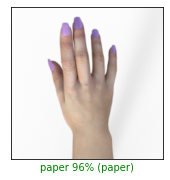

In [186]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Create a file to save the labels.

In [187]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

If you are running this notebook in a Colab, you can run the cell below to download the model and labels to your local disk.

**Note**: If the files do not download when you run the cell, try running the cell a second time. Your browser might prompt you to allow multiple files to be downloaded. 

In [188]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Prepare the Test Images for Download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [189]:
!mkdir -p test_images

In [190]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [191]:
!ls test_images

paper_0.jpg   paper_27.jpg  rock_15.jpg  rock_38.jpg	  scissors_17.jpg
paper_12.jpg  paper_2.jpg   rock_1.jpg	 rock_39.jpg	  scissors_29.jpg
paper_14.jpg  paper_31.jpg  rock_20.jpg  rock_41.jpg	  scissors_33.jpg
paper_18.jpg  paper_3.jpg   rock_21.jpg  rock_42.jpg	  scissors_37.jpg
paper_19.jpg  paper_40.jpg  rock_28.jpg  rock_43.jpg	  scissors_46.jpg
paper_22.jpg  paper_45.jpg  rock_30.jpg  rock_44.jpg	  scissors_4.jpg
paper_23.jpg  paper_48.jpg  rock_32.jpg  rock_47.jpg	  scissors_5.jpg
paper_24.jpg  paper_49.jpg  rock_34.jpg  rock_9.jpg	  scissors_6.jpg
paper_25.jpg  rock_11.jpg   rock_35.jpg  scissors_10.jpg  scissors_7.jpg
paper_26.jpg  rock_13.jpg   rock_36.jpg  scissors_16.jpg  scissors_8.jpg


In [192]:
!zip -qq rps_test_images.zip -r test_images/

If you are running this notebook in a Colab, you can run the cell below to download the Zip file with the images to your local disk. 

**Note**: If the Zip file does not download when you run the cell, try running the cell a second time.

In [193]:
try:
    files.download('rps_test_images.zip')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

For further learning consider end to end projects on raspberry pi: 

https://github.com/https-deeplearning-ai/tensorflow-2-public/tree/main/C2_Device-based-TF-lite/W4/ungraded_labs 